#1.Import Dependencies

In [1]:
import sys
sys.path.append('C:/Users/57lzhang.US04WW4008/PycharmProjects/AF')

In [2]:
from util import util, model_util
import tensorflow as tf
from datetime import datetime
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
import numpy as np
import sklearn
from sklearn import metrics
import scipy
import matplotlib.pyplot as plt
print(tf.__version__)

2.3.1


In [3]:
import io
import itertools
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, Conv1D, BatchNormalization, Input, Add, Activation, \
    MaxPooling1D, MaxPooling2D, Dropout, Flatten, TimeDistributed, Bidirectional, Dense, LSTM, ZeroPadding1D, \
    AveragePooling1D, GlobalAveragePooling1D, Concatenate, Permute, Dot, Multiply, RepeatVector, \
    Lambda, Average, GlobalAveragePooling2D, DepthwiseConv2D
from tensorflow.keras.initializers import glorot_uniform

#2.Input Data Pipeline

##2.1 Load and Process

In [41]:
# load training data
train_data_file_path = "C:/Users/57lzhang.US04WW4008/Desktop/Afib/Afib data/Afib ECG data/training2017/"
raw_signals, raw_labels = util.data_mining(train_data_file_path)
signals, labels = util.generate_seg_data(raw_signals, raw_labels, seg_len=9000)
signals, labels = util.preprocessing(signals, labels, timedistributed=False)
train_signals, train_labels, val_signals, val_labels = util.split_shuffle_dataset(signals, labels, 0.9)
#oversample labels
train_signals, train_labels = util.oversample_labels(train_signals, train_labels)
val_signals, val_labels = util.oversample_labels(val_signals, val_labels)

print('train_signal shape:', train_signals.shape)
print('train_label shape:', train_labels.shape)
print("\nIn training data:") 
util.count_labels(train_labels)
print("\nIn validation data:")
util.count_labels(val_labels)

train_signal shape: (13290, 3000, 1)
train_label shape: (13290,)

In training data:
There are 4430 NSR labels
There are 4430 AF labels
There are 4430 Other Arrhythmia labels

In validation data:
There are 502 NSR labels
There are 502 AF labels
There are 502 Other Arrhythmia labels


(502, 502, 502)

In [42]:
# load testing data
test_data_file_path = "C:/Users/57lzhang.US04WW4008/Desktop/Afib/Afib data/Afib ECG data/validation/"
test_raw_signals, test_raw_labels = util.data_mining(test_data_file_path)
test_signals, test_labels = util.generate_seg_data(test_raw_signals, test_raw_labels, seg_len=9000)
test_signals, test_labels = util.preprocessing(test_signals, test_labels, timedistributed=False)
print('test_signal shape:', test_signals.shape)
print('test_label shape:', test_labels.shape)
print("\nIn test data:") 
util.count_labels(test_labels)

test_signal shape: (276, 3000, 1)
test_label shape: (276, 1)

In test data:
There are 150 NSR labels
There are 47 AF labels
There are 79 Other Arrhythmia labels


(150, 47, 79)

In [43]:
#convert test labels to floating point type, so that it can be compared with model output
test_labels = test_labels.flatten()
test_labels = test_labels.astype(int)
type(test_labels[0])

numpy.int32

##2.2.TF Pipeline

In [44]:
# tensorflow pipeline
## extraction
train_dataset = tf.data.Dataset.from_tensor_slices((train_signals, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_signals, val_labels))
## loading
batch_size = 128
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(2048).repeat().batch(batch_size, drop_remainder=True)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.repeat().batch(batch_size, drop_remainder=True)

In [45]:
train_dataset

<PrefetchDataset shapes: ((128, 3000, 1), (128,)), types: (tf.float64, tf.int32)>

In [46]:
val_dataset

<BatchDataset shapes: ((128, 3000, 1), (128,)), types: (tf.float64, tf.int32)>

#3.Model

##3.1.Training with Time-Domain

###Short CNN-1D

In [36]:
model = model_util.simple_cnn_1d((3000, 1), dropout=0.2, classes=3)
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

Model: "cnn_1d"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 3000, 1)]         0         
_________________________________________________________________
conv1d_104 (Conv1D)          (None, 3000, 8)           16        
_________________________________________________________________
batch_normalization_193 (Bat (None, 3000, 8)           32        
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 1500, 8)           0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 1500, 8)           0         
_________________________________________________________________
conv1d_105 (Conv1D)          (None, 1498, 16)          400       
_________________________________________________________________
batch_normalization_194 (Bat (None, 1498, 16)          64   

###MobileNet-1D

In [47]:
model = model_util.MobileNet_1D(input_shape=(3000,1), dropout=0.5, classes=3)
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])
model.summary()

Model: "mobilenet_1d"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 3000, 1)]         0         
_________________________________________________________________
conv1d_127 (Conv1D)          (None, 1500, 32)          96        
_________________________________________________________________
batch_normalization_233 (Bat (None, 1500, 32)          128       
_________________________________________________________________
activation_221 (Activation)  (None, 1500, 32)          0         
_________________________________________________________________
depthwise_conv1d_104 (Depthw (None, 1500, 32)          96        
_________________________________________________________________
batch_normalization_234 (Bat (None, 1500, 32)          128       
_________________________________________________________________
activation_222 (Activation)  (None, 1500, 32)         

###LSTM

In [ ]:
#cnn + lstm model
model = model_util.cnn_lstm((3,1250,1), classes=3)
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

In [ ]:
model = model_util.resnet18_lstm(3, 32, 16, 1250, classes=3)
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

##3.2 Training with Autoencoder

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv1D, BatchNormalization, Input, Add, Activation, \
    MaxPooling1D, Dropout, Flatten, TimeDistributed, Bidirectional, Dense, LSTM, ZeroPadding1D, \
    AveragePooling1D, Conv1DTranspose, GlobalMaxPooling1D, Concatenate, Permute, Dot, Multiply, RepeatVector, \
    Lambda, Average

In [ ]:
import os
os.chdir(r"C:\Users\57lzhang.US04WW4008\Desktop\Afib\Afib data\models")
ecg_encoder = tf.keras.models.load_model('ECG_Encoder.h5')
conv_encoder_clone = tf.keras.models.clone_model(ecg_encoder)

In [ ]:
def encoder_lstm(input_shape=(3,1250,1), classes=3):
  X_input = Input(shape=input_shape)
  X = TimeDistributed(conv_encoder_clone)(X_input)
  X = TimeDistributed(Flatten())(X)
  X = Bidirectional(LSTM(32, return_sequences=True))(X)
  X = Bidirectional(LSTM(16))(X)
  X = Dense(classes, activation='softmax')(X)

  model = Model(inputs=[X_input], outputs=X)

  return model

In [ ]:
model = encoder_lstm(input_shape=(3,1250,1), classes=3)

In [ ]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 3, 1250, 1)]      0         
_________________________________________________________________
time_distributed_9 (TimeDist (None, 3, 1250, 16)       53328     
_________________________________________________________________
time_distributed_10 (TimeDis (None, 3, 20000)          0         
_________________________________________________________________
bidirectional_9 (Bidirection (None, 3, 64)             5128448   
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 32)                10368     
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 99        
Total params: 5,192,243
Trainable params: 5,138,915
Non-trainable params: 53,328
_______________________________________

In [ ]:
conv_encoder_clone.trainable = False
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
CLASS_WEIGHTS = util.class_weights(train_labels)

model.fit(train_dataset,
          epochs=200,
          steps_per_epoch=len(list(train_signals))//batch_size,
          verbose=1,
          validation_data=val_dataset,
          validation_steps=len(list(val_signals))//batch_size,
          callbacks=callbacks_list,
          class_weight=CLASS_WEIGHTS)

##3.3 Training with Spectrogram

In [ ]:
train_data_file_path = "C:/Users/57lzhang.US04WW4008/Desktop/Afib/Afib data/Afib ECG data/training2017/"
raw_signals, raw_labels = util.data_mining(train_data_file_path)
signals, labels = util.generate_seg_data(raw_signals, raw_labels, seg_len=9000)

In [ ]:
def get_spectrogram(signal):
  freq, time, spectrogram = scipy.signal.spectrogram(signal, fs=300, window='hanning',
                                                     nperseg=1024, noverlap=1024 - 128,
                                                     detrend=False, scaling='spectrum',
                                                     nfft=1024)
  spectrogram = np.log(spectrogram[(freq <= 10) & (freq > 0.01)])
  spectrogram = sklearn.preprocessing.minmax_scale(spectrogram)
  return spectrogram

In [ ]:
get_spectrogram(signals[0]).shape

(34, 63)

In [ ]:
def plot_spectrogram(signals, labels, type=0):
  
  type_idx = np.where(labels == type)[0]
  i = np.random.choice(type_idx, 1)
  i = int(i)  
  def get_label(label):
    if label == 0:
      return 'NSR'
    if label == 1:
      return 'AF'
    if label == 2:
      return 'Others'
  
  spectrogram = get_spectrogram(signals[i])

  fig, axes = plt.subplots(2, figsize=(12, 8))
  fig.tight_layout(pad=5.0)
  #ECG raw signal
  axes[0].plot(signals[0])
  axes[0].set_title(get_label(labels[i]))
  axes[0].set_xlabel('Samples', fontsize=15)
  axes[0].set_ylabel('ADC counts', fontsize=15)
  #spectrogram
  im = axes[1].pcolormesh(spectrogram)
  fig.colorbar(im, ax=axes[1])
  axes[1].set_title('Spectrogram', fontsize=15)
  axes[1].set_ylabel('Frequency (Hz)', fontsize=15)
  axes[1].set_xlabel('Samples', fontsize=15)
  plt.show()

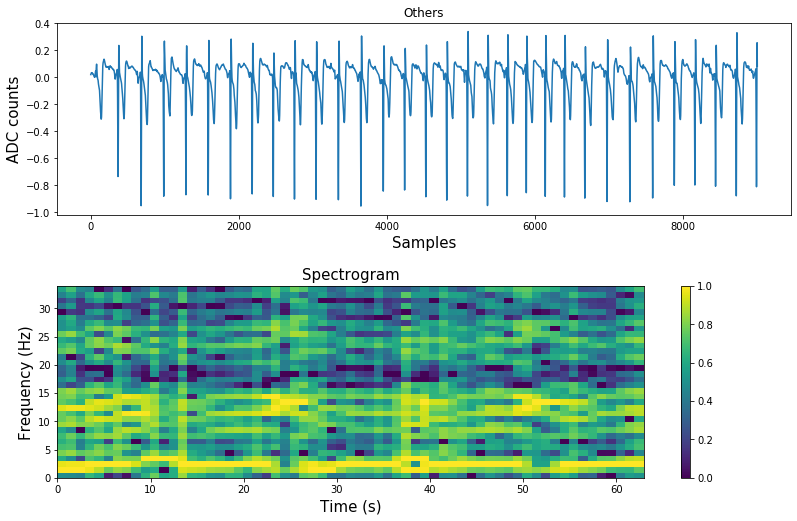

In [ ]:
plot_spectrogram(signals, labels, 2)

In [ ]:
def get_spectrogram_and_label(signal, label):
  spectrogram = tf.py_function(get_spectrogram, inp=[signal], Tout=tf.float32)
  spectrogram = tf.expand_dims(spectrogram, -1)
  return spectrogram, label

In [ ]:
spectrogram, label = get_spectrogram_and_label(signals[0], labels[0])

In [ ]:
type(spectrogram)

tensorflow.python.framework.ops.EagerTensor

In [ ]:
print('Spectrom shape:', get_spectrogram_and_label(signals[0], labels[0])[0].shape)
print('Label shape:', get_spectrogram_and_label(signals[0], labels[0])[1].shape)

Spectrom shape: (34, 63, 1)
Label shape: (1,)


In [ ]:
train_signals, train_labels, val_signals, val_labels = util.split_shuffle_dataset(signals, labels, 0.9, seed=10)

In [ ]:
print('train_signal shape:', train_signals.shape)
print('train_label shape:', train_labels.shape)
print("\nIn training data:") 
util.count_labels(train_labels)
print("\nIn validation data:")
util.count_labels(val_labels)

train_signal shape: (7425, 9000)
train_label shape: (7425, 1)

In training data:
There are 4430 NSR labels
There are 653 AF labels
There are 2342 Other Arrhythmia labels

In validation data:
There are 502 NSR labels
There are 62 AF labels
There are 261 Other Arrhythmia labels


(502, 62, 261)

In [ ]:
# tensorflow pipeline
## extraction
train_dataset = tf.data.Dataset.from_tensor_slices((train_signals, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_signals, val_labels))
train_dataset = train_dataset.map(get_spectrogram_and_label, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.map(get_spectrogram_and_label, num_parallel_calls=tf.data.experimental.AUTOTUNE)

## loading
batch_size = 64
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(2048).repeat().batch(batch_size, drop_remainder=True)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.repeat().batch(batch_size, drop_remainder=True)

In [ ]:
list(train_dataset.take(1).as_numpy_iterator())

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv1D, BatchNormalization, Input, Add, Activation, \
    MaxPooling1D, Dropout, Flatten, TimeDistributed, Bidirectional, Dense, LSTM, ZeroPadding1D, \
    AveragePooling1D, Conv1DTranspose, GlobalMaxPooling1D, Concatenate, Permute, Dot, Multiply, RepeatVector, \
    Lambda, Average
    
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    #1st Conv2D
    tf.keras.layers.Input(shape=(34,63,1)),
    tf.keras.layers.experimental.preprocessing.Normalization(),
    tf.keras.layers.Conv2D(8, (1, 1), strides=(1, 1), 
                           activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2)),
    #tf.keras.layers.Dropout(0.2),
    #2nd Conv2D
    tf.keras.layers.Conv2D(16, (3, 3), strides=(1, 1),
                           activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(1, 1)),
    #tf.keras.layers.Dropout(0.2),
    #3rd Conv2D
    tf.keras.layers.Conv2D(32, (3, 3), strides=(1, 1),
                           activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(1, 1)),
    #tf.keras.layers.Dropout(0.2),
    #4th Conv2D
    tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1),
                           activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(1, 1)),
    tf.keras.layers.Dropout(0.2),
    #5th Conv2D
    tf.keras.layers.Conv2D(16, (1, 1), strides=(1, 1),
                           activation='relu'),
    #Full connection layer
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 34, 63, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 34, 63, 8)         16        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 17, 31, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 29, 16)        1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 28, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 26, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 25, 32)        0

In [ ]:
model = model_util.MobileNet(input_shape=(34,63,1), dropout=0.5, alpha=0.5, classes=3)

In [ ]:
model.summary()

In [ ]:
val_spectrogram = []
for val_signal in val_signals:
  val_spectrogram.append(get_spectrogram(val_signal))

val_signals_cm = np.array(val_spectrogram)
val_signals_cm = tf.expand_dims(val_signals_cm, -1)
val_signals_cm.shape

TensorShape([825, 34, 63, 1])

In [ ]:
# callbacks
log_dir = r"C:\Users\57lzhang.US04WW4008\Desktop\Afib\Afib data\logs\fit\\" + \
          datetime.now().strftime("%Y%m%d-%H%M%S") + "resnet"

## confusion matrix callback
def log_confusion_matrix(epoch, logs):
    # Use the model to predict the values from the test_images.
    
    test_pred_raw = model.predict(val_signals_cm)

    test_pred = np.argmax(test_pred_raw, axis=1)
    test_labels = val_labels.reshape([len(val_labels)])
    # Calculate the confusion matrix using sklearn.metrics
    cm = sklearn.metrics.confusion_matrix(test_labels, test_pred)

    figure = model_util.plot_confusion_matrix(cm, class_names=class_names, normalize=True)
    cm_image = model_util.plot_to_image(figure)

    # Log the confusion matrix as an image summary.
    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)

class_names = ['NSR','Afib','Others']
file_writer_cm = tf.summary.create_file_writer(log_dir + '/cm')
cm_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)

## tensorboard callback
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

## checkpoint callback
filepath = r"C:\Users\57lzhang.US04WW4008\Desktop\Afib\Afib data\models\resnet-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='auto')

## learning rate decay callback
lr_schedule = tf.keras.callbacks.LearningRateScheduler(model_util.decay)

callbacks_list = [tensorboard_callback, cm_callback, checkpoint, lr_schedule]

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
#model training
CLASS_WEIGHTS = util.class_weights(train_labels)

model.fit(train_dataset,
          epochs=200,
          steps_per_epoch=len(list(train_signals))//batch_size,
          verbose=1,
          validation_data=val_dataset,
          validation_steps=len(list(val_signals))//batch_size,
          callbacks=callbacks_list,
          class_weight=CLASS_WEIGHTS)

##3.4 Training with both time-domain and frequency-domain

###Prepare time-domain data

In [ ]:
# load training data
train_data_file_path = "C:/Users/57lzhang.US04WW4008/Desktop/Afib/Afib data/Afib ECG data/training2017/"
raw_signals, raw_labels = util.data_mining(train_data_file_path)
signals, labels = util.generate_seg_data(raw_signals, raw_labels, seg_len=9000)

In [ ]:
signals.shape

(8250, 9000)

In [ ]:
t_signals, t_labels = util.preprocessing(signals, labels, timedistributed=False)
t_train_signals, train_labels, t_val_signals, val_labels = util.split_shuffle_dataset(t_signals, t_labels, 0.9, seed=10)
print('t_train_signal shape:', t_train_signals.shape)
print('train_label shape:', train_labels.shape)
print("\nIn training data:") 
util.count_labels(train_labels)
print("\nIn validation data:")
util.count_labels(val_labels)

t_train_signal shape: (7425, 3750, 1)
train_label shape: (7425, 1)

In training data:
There are 4430 NSR labels
There are 653 AF labels
There are 2342 Other Arrhythmia labels

In validation data:
There are 502 NSR labels
There are 62 AF labels
There are 261 Other Arrhythmia labels


(502, 62, 261)

###Prepare frequency-domain data

In [ ]:
def get_spectrogram(signal):
  freq, time, spectrogram = scipy.signal.spectrogram(signal, fs=300, window='hanning',
                                                     nperseg=1024, noverlap=1024 - 128,
                                                     detrend=False, scaling='spectrum',
                                                     nfft=1024)
  spectrogram = np.log(spectrogram[(freq <= 10) & (freq > 0.01)])
  spectrogram = sklearn.preprocessing.minmax_scale(spectrogram)
  return spectrogram

In [ ]:
def get_spectrogram_tensor(signal):
  spectrogram = tf.py_function(get_spectrogram, inp=[signal], Tout=tf.float32)
  spectrogram = tf.expand_dims(spectrogram, -1)
  return spectrogram

In [ ]:
f_train_signals, _, f_val_signals, _ = util.split_shuffle_dataset(signals, labels, 0.9, seed=10)
print('f_train_signal shape:', f_train_signals.shape)

f_train_signal shape: (7425, 9000)


###TF pipeline

In [ ]:
#time domain
t_train_dataset = tf.data.Dataset.from_tensor_slices(t_train_signals)
t_val_dataset = tf.data.Dataset.from_tensor_slices(t_val_signals)

#freq domain
f_train_dataset = tf.data.Dataset.from_tensor_slices(f_train_signals)
f_val_dataset = tf.data.Dataset.from_tensor_slices(f_val_signals)
f_train_dataset = f_train_dataset.map(get_spectrogram_tensor, num_parallel_calls=tf.data.experimental.AUTOTUNE)
f_val_dataset = f_val_dataset.map(get_spectrogram_tensor, num_parallel_calls=tf.data.experimental.AUTOTUNE)

#label
train_lb = tf.data.Dataset.from_tensor_slices(train_labels)
val_lb = tf.data.Dataset.from_tensor_slices(val_labels)

train = tf.data.Dataset.zip(((t_train_dataset, f_train_dataset), train_lb))
validation = tf.data.Dataset.zip(((t_val_dataset, f_val_dataset), val_lb))

## loading
batch_size = 64
train_dataset = train.cache()
train_dataset = train_dataset.shuffle(2048).repeat().batch(batch_size, drop_remainder=True)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_dataset = validation.repeat().batch(batch_size, drop_remainder=True)

In [ ]:
train

<ZipDataset shapes: (((3750, 1), <unknown>), (1,)), types: ((tf.float64, tf.float32), tf.int32)>

###Mutilple input model


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import io
import itertools
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, Conv1D, BatchNormalization, Input, Add, Activation, \
    MaxPooling1D, MaxPooling2D, Dropout, Flatten, TimeDistributed, Bidirectional, Dense, LSTM, ZeroPadding1D, \
    AveragePooling1D, GlobalAveragePooling1D, Concatenate, Permute, Dot, Multiply, RepeatVector, \
    Lambda, Average, GlobalAveragePooling2D, DepthwiseConv2D
from tensorflow.keras.initializers import glorot_uniform

In [ ]:
def time_freq_model(input_shape=None, classes=3, dropout=0.2):
  time_input = Input(shape = (3750, 1))
  freq_input = Input(shape = (34, 63, 1))

  x_t = simple_cnn_1d(input_shape=(3750,1), dropout=dropout)(time_input)
  x_f = simple_cnn(input_shape=(34, 63, 1), dropout=dropout)(freq_input)

  x = Concatenate(axis=-1)([x_t, x_f])
  output = Dense(classes, activation='softmax')(x)
  model = Model(inputs = (time_input, freq_input), outputs = output)
  return model

In [ ]:
model = time_freq_model(classes=3, dropout=0.5)

In [ ]:
model.summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_48 (InputLayer)           [(None, 3750, 1)]    0                                            
__________________________________________________________________________________________________
input_49 (InputLayer)           [(None, 34, 63, 1)]  0                                            
__________________________________________________________________________________________________
cnn_1d (Functional)             (None, 64)           1920112     input_48[0][0]                   
__________________________________________________________________________________________________
cnn_2d (Functional)             (None, 64)           205680      input_49[0][0]                   
______________________________________________________________________________________

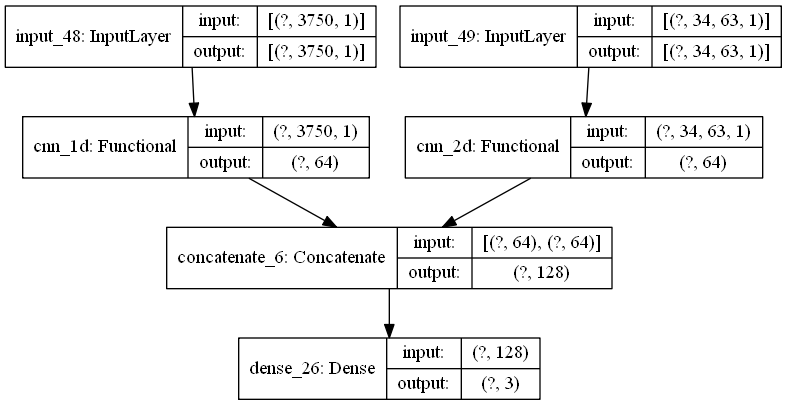

In [ ]:
tf.keras.utils.plot_model(model, "C:/Users/57lzhang.US04WW4008/Desktop/multi_input_and_output_model.png", show_shapes=True)

In [ ]:
# callbacks
log_dir = r"C:\Users\57lzhang.US04WW4008\Desktop\Afib\Afib data\logs\fit\\" + \
          datetime.now().strftime("%Y%m%d-%H%M%S") + "resnet"


## tensorboard callback
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

## checkpoint callback
filepath = r"C:\Users\57lzhang.US04WW4008\Desktop\Afib\Afib data\models\resnet-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='auto')

## learning rate decay callback
lr_schedule = tf.keras.callbacks.LearningRateScheduler(model_util.decay)

callbacks_list = [tensorboard_callback, checkpoint, lr_schedule]

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
#model training
CLASS_WEIGHTS = util.class_weights(train_labels)

model.fit(train_dataset,
          epochs=200,
          steps_per_epoch=len(list(t_train_signals))//batch_size,
          verbose=1,
          validation_data=val_dataset,
          validation_steps=len(list(t_val_signals))//batch_size,
          callbacks=callbacks_list,
          class_weight=CLASS_WEIGHTS)

###Mutiple Input model - simple CNN

In [ ]:
def simple_cnn(input_shape=None, dropout=0.2, classes=3):
    
    signal_input = Input(shape=input_shape)
    
    x = Conv2D(8, (1, 1), strides=(1, 1), activation='relu')(signal_input)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2),strides=(2, 2))(x)
    #tf.keras.layers.Dropout(0.2),
    #2nd Conv2D
    x = Conv2D(16, (3, 3), strides=(1, 1), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2),strides=(1, 1))(x)
    #tf.keras.layers.Dropout(0.2),
    #3rd Conv2D
    x = Conv2D(32, (3, 3), strides=(1, 1), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2),strides=(1, 1))(x)
    #tf.keras.layers.Dropout(0.2),
    #4th Conv2D
    x = Conv2D(64, (3, 3), strides=(1, 1), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2),strides=(1, 1))(x)
    x = Dropout(dropout)(x)
    #5th Conv2D
    x = Conv2D(16, (1, 1), strides=(1, 1), activation='relu')(x)
    #Full connection layer
    x = Flatten()(x)
    out = Dense(64, activation='relu')(x)
    model = Model(signal_input, out, name='cnn_2d')

    return model

In [ ]:
def simple_cnn_1d(input_shape=None, dropout=0.2, classes=3):   
    
    signal_input = Input(shape=input_shape)
    
    x = Conv1D(8, 1, strides=1, activation='relu')(signal_input)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2,strides=2)(x)
    #tf.keras.layers.Dropout(0.2),
    #2nd Conv1D
    x = Conv1D(16, 3, strides=1, activation='relu')(x)
    x = MaxPooling1D(pool_size=2, strides=1)(x)
    #tf.keras.layers.Dropout(0.2),
    #3rd Conv1D
    x = Conv1D(32, 3, strides=1, activation='relu')(x)
    x = MaxPooling1D(pool_size=2, strides=1)(x)
    #tf.keras.layers.Dropout(0.2),
    #4th Conv1D
    x = Conv1D(64, 3, strides=1, activation='relu')(x)
    x = MaxPooling1D(pool_size=2, strides=1)(x)
    x = Dropout(dropout)(x)
    #5th Conv1D
    x = Conv1D(16, 1, strides=1, activation='relu')(x)
    #Full connection layer
    x = Flatten()(x)
    out = Dense(64, activation='relu')(x)
    model = Model(signal_input, out, name='cnn_1d')

    return model

#4.Callbacks

In [48]:
# callbacks
log_dir = r"C:\Users\57lzhang.US04WW4008\Desktop\Afib\Afib data\logs\fit\\" + \
          datetime.now().strftime("%Y%m%d-%H%M%S") + "mobile-time-noshift-100Hz"

## confusion matrix callback
def log_confusion_matrix(epoch, logs):
    # Use the model to predict the values from the test_images.
    
    test_pred_raw = model.predict(val_signals)

    test_pred = np.argmax(test_pred_raw, axis=1)
    test_labels = val_labels.reshape([len(val_labels)])
    # Calculate the confusion matrix using sklearn.metrics
    cm = sklearn.metrics.confusion_matrix(test_labels, test_pred)

    figure = model_util.plot_confusion_matrix(cm, class_names=class_names, normalize=True)
    cm_image = model_util.plot_to_image(figure)

    # Log the confusion matrix as an image summary.
    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)

class_names = ['NSR','Afib','Others']
file_writer_cm = tf.summary.create_file_writer(log_dir + '/cm')
cm_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)

## tensorboard callback
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

## checkpoint callback
filepath = r"C:\Users\57lzhang.US04WW4008\Desktop\Afib\Afib data\models\mobile-time-noshift-100Hz-{epoch:02d}-{loss:.4f}"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='auto')

## early stop
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

## learning rate decay callback
lr_schedule = tf.keras.callbacks.LearningRateScheduler(model_util.decay)

callbacks_list = [tensorboard_callback, cm_callback, checkpoint, early_stop, lr_schedule]

#5.Model Training

In [ ]:
#model training
model.fit(train_dataset,
          epochs=200,
          steps_per_epoch=len(list(train_signals))//batch_size,
          verbose=1,
          validation_data=val_dataset,
          validation_steps=len(list(val_signals))//batch_size,
          callbacks=callbacks_list)

#6.Model Evaluation

In [24]:
model = tf.keras.models.load_model(r'C:\Users\57lzhang.US04WW4008\Desktop\Afib\Afib data\models\mobile-drop0.5+time-25Hz-71-0.0001')

In [50]:
test_pred_raw = model.predict(test_signals)
test_pred = np.argmax(test_pred_raw, axis=1)

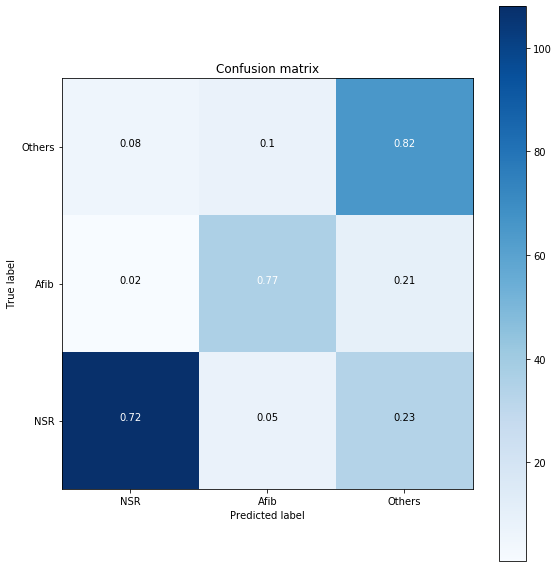

In [72]:
cm = sklearn.metrics.confusion_matrix(test_labels, test_pred)
figure = model_util.plot_confusion_matrix(cm, class_names=class_names, normalize=True)

In [73]:
sklearn.metrics.f1_score(test_labels, test_pred, average='weighted')

0.764759524274212